In [2]:
# Algorithm 1: Four-query Clifford Tester
# https://www.arxiv.org/abs/2510.07164 pg. 21

import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

from lib import weyl_choi_state
from lib.measurements import measure_bell_basis

In [4]:
def get_clifford_tester_circuit(U_circuit: QuantumCircuit, n: int, x: list) -> QuantumCircuit:
    """
    Build the circuit for one run of the four-query Clifford tester.

    Creates a circuit that:
    1. Prepares two copies of |P_x⟩⟩ (Choi state)
    2. Applies U^{⊗2} to each copy
    3. Measures each in the Bell basis

    Args:
        U_circuit: A quantum circuit implementing the n-qubit unitary U
        n: Number of qubits U acts on
        x: 2n-bit string specifying which Weyl operator to use

    Returns:
        QuantumCircuit with 4n qubits and 4n classical bits
    """
    # We need 4n qubits total:
    # |P_x⟩⟩ is a 2n-qubit state (Choi state of n-qubit operator)
    # U^{⊗2}|P_x⟩⟩ applies U to both halves of the Choi state
    # We need two independent copies of this, so 4n qubits total

    qc = QuantumCircuit(4*n, 4*n)

    # Qubit layout:
    # Copy 1: qubits 0 to n-1 (A1), qubits n to 2n-1 (B1)
    # Copy 2: qubits 2n to 3n-1 (A2), qubits 3n to 4n-1 (B2)
    A1 = list(range(0, n))
    B1 = list(range(n, 2*n))
    A2 = list(range(2*n, 3*n))
    B2 = list(range(3*n, 4*n))

    # Step 1: Prepare |P_x⟩⟩ for both copies
    choi = weyl_choi_state(n, x)
    qc.append(choi, A1 + B1)
    qc.append(choi, A2 + B2)

    qc.barrier()

    # Step 2: Apply U^{⊗2} = U ⊗ U to each copy
    # This means applying U to A1, U to B1, U to A2, U to B2
    for qubits in [A1, B1, A2, B2]:
        qc.compose(U_circuit, qubits=qubits, inplace=True)

    qc.barrier()

    # Step 3: Measure each copy in Bell basis
    c1 = list(range(0, 2*n))      # Classical bits for copy 1
    c2 = list(range(2*n, 4*n))    # Classical bits for copy 2

    measure_bell_basis(qc, A1, B1, c1)
    measure_bell_basis(qc, A2, B2, c2)

    return qc

In [ ]:
def clifford_tester(U_circuit: QuantumCircuit, n: int, shots: int = 1000):
    """
    Four-query Clifford tester algorithm.
    
    Tests whether a unitary U is a Clifford gate by:
    1. Sampling random x from F_2^{2n}
    2. Preparing two copies of U^{⊗2}|P_x⟩⟩
    3. Measuring each in the Bell basis to get y and y'
    4. Accepting if y = y'
    
    Args:
        U_circuit: A quantum circuit implementing the n-qubit unitary U
        n: Number of qubits U acts on
        shots: Number of times to run the test
        
    Returns:
        acceptance_rate: Fraction of runs where y = y'
    """
    accepts = 0
    simulator = AerSimulator()
    
    for _ in range(shots):
        # Sample random x from F_2^{2n}
        x = list(np.random.randint(0, 2, size=2*n))
        
        # Build and fully decompose the circuit (reps=3 handles nested gates)
        qc = get_clifford_tester_circuit(U_circuit, n, x)
        qc = qc.decompose(reps=3)
        
        # Run the circuit
        result = simulator.run(qc, shots=1).result()
        counts = result.get_counts()
        
        # Get the measurement outcome (should be just one since shots=1)
        outcome = list(counts.keys())[0]
        
        # Split into y and y' (Qiskit returns bits in reverse order)
        # outcome is a 4n-bit string, first 2n bits are c2, last 2n bits are c1
        y_prime = outcome[:2*n]   # Copy 2 result
        y = outcome[2*n:]         # Copy 1 result
        
        # Accept if y = y'
        if y == y_prime:
            accepts += 1
    
    return accepts / shots

In [14]:
# Test with Clifford gates (should accept with high probability)
print("Testing Clifford gates:")

# Hadamard (Clifford)
H = QuantumCircuit(1)
H.h(0)
print(f"  Hadamard acceptance rate: {clifford_tester(H, 1, shots=100):.2f}")

# S gate (Clifford)
S = QuantumCircuit(1)
S.s(0)
print(f"  S gate acceptance rate: {clifford_tester(S, 1, shots=100):.2f}")

# CNOT (Clifford, 2-qubit)
CNOT = QuantumCircuit(2)
CNOT.cx(0, 1)
print(f"  CNOT acceptance rate: {clifford_tester(CNOT, 2, shots=100):.2f}")

# Identity (Clifford)
I = QuantumCircuit(1)
print(f"  Identity acceptance rate: {clifford_tester(I, 1, shots=100):.2f}")

Testing Clifford gates:
10 10
11 11
10 10
11 11
11 11
01 01
10 10
01 01
10 10
11 11
10 10
01 01
00 00
10 10
11 11
00 00
10 10
11 11
10 10
11 11
00 00
00 00
10 10
00 00
10 10
01 01
01 01
11 11
10 10
00 00
10 10
01 01
11 11
11 11
00 00
00 00
10 10
00 00
10 10
00 00
00 00
11 11
11 11
00 00
10 10
10 10
10 10
00 00
01 01
01 01
01 01
00 00
10 10
01 01
11 11
00 00
01 01
00 00
11 11
11 11
10 10
01 01
00 00
10 10
01 01
10 10
10 10
01 01
10 10
01 01
11 11
01 01
00 00
11 11
10 10
01 01
01 01
00 00
10 10
10 10
11 11
11 11
10 10
11 11
01 01
11 11
11 11
10 10
10 10
10 10
11 11
11 11
11 11
00 00
10 10
11 11
01 01
10 10
11 11
11 11
  Hadamard acceptance rate: 1.00


In [7]:
# Test with non-Clifford gates (should reject with noticeable probability)
print("\nTesting non-Clifford gates:")

# T gate (non-Clifford)
T = QuantumCircuit(1)
T.t(0)
print(f"  T gate acceptance rate: {clifford_tester(T, 1, shots=100):.2f}")

# Rotation by arbitrary angle (non-Clifford)
Rx = QuantumCircuit(1)
Rx.rx(0.3, 0)  # Arbitrary rotation angle
print(f"  Rx(0.3) acceptance rate: {clifford_tester(Rx, 1, shots=100):.2f}")

# Toffoli (non-Clifford, 3-qubit)
Toffoli = QuantumCircuit(3)
Toffoli.ccx(0, 1, 2)
print(f"  Toffoli acceptance rate: {clifford_tester(Toffoli, 3, shots=100):.2f}")


Testing non-Clifford gates:
  T gate acceptance rate: 0.72
  Rx(0.3) acceptance rate: 0.94
  Toffoli acceptance rate: 0.33


In [16]:
# Test with larger 7-qubit gates to check simulator performance
print("\nTesting 7-qubit gates:")

# 7-qubit Clifford: H on all qubits + chain of CNOTs
clifford_7 = QuantumCircuit(7)
for i in range(7):
    clifford_7.h(i)
for i in range(6):
    clifford_7.cx(i, i+1)
print(f"  7-qubit Clifford (H + CNOT chain) acceptance rate: {clifford_tester(clifford_7, 7, shots=10):.2f}")

# 7-qubit non-Clifford: T gates on all qubits
non_clifford_7 = QuantumCircuit(7)
for i in range(7):
    non_clifford_7.t(i)
print(f"  7-qubit non-Clifford (T gates) acceptance rate: {clifford_tester(non_clifford_7, 7, shots=10):.2f}")


Testing 7-qubit gates:
01110100010001 01110100010001
10010100001011 10010100001011
10100111111001 10100111111001
10011011111001 10011011111001
10000100100111 10000100100111
11011111001110 11011111001110
00110111100001 00110111100001
01110100101110 01110100101110
01011001011001 01011001011001
11101010000110 11101010000110
  7-qubit Clifford (H + CNOT chain) acceptance rate: 1.00
11010100010011 11010100010011
10101010011111 00101010011111
11111001110100 11101111110100
00101000101100 10001000101100
11100011101101 11100011101101
01000000101101 11100100101101
10111001111001 10110001111001
00010000011001 11011100011001
00110000001000 11110110001000
10110110100100 00110100100100
  7-qubit non-Clifford (T gates) acceptance rate: 0.20


Entire Weyl-Choi state
Bell state + Weyl operator
Base gates


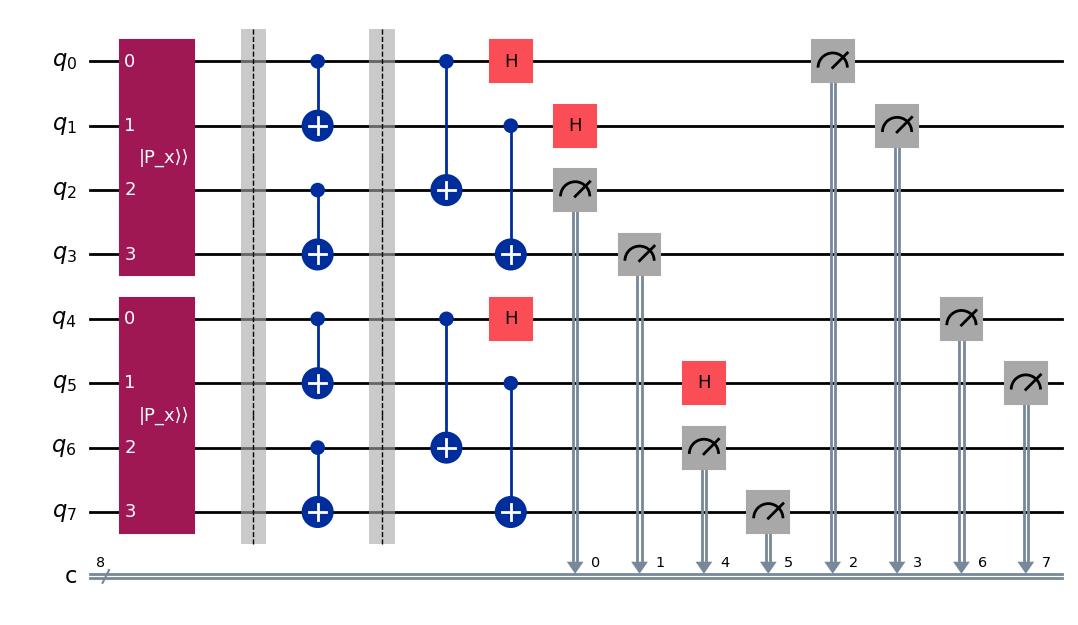

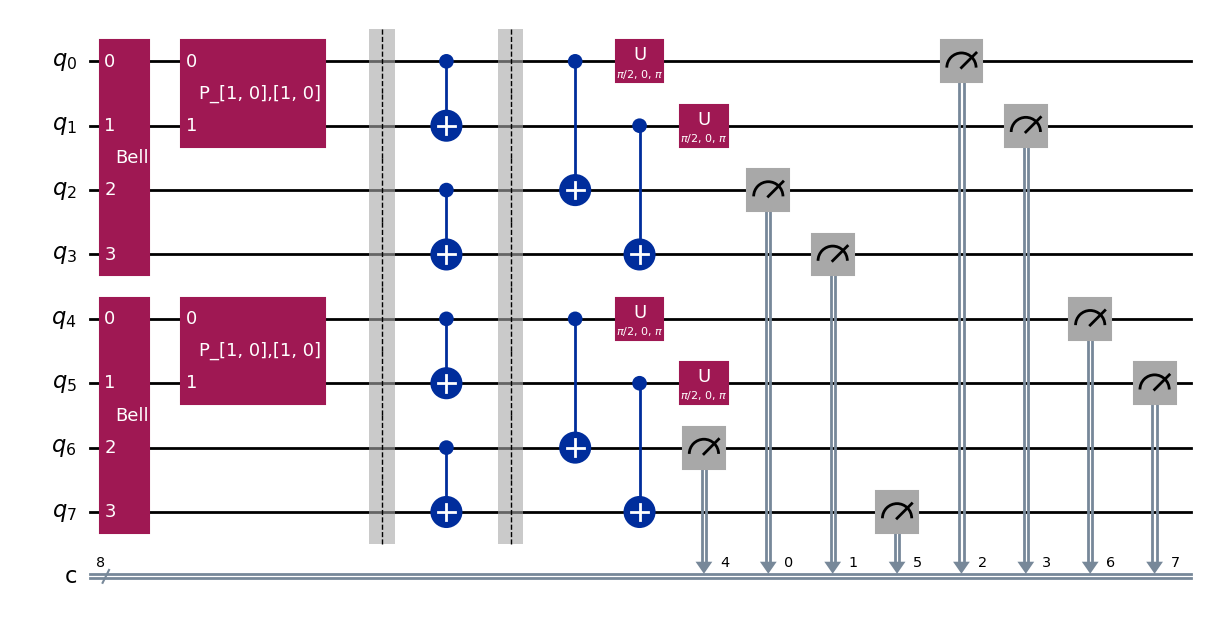

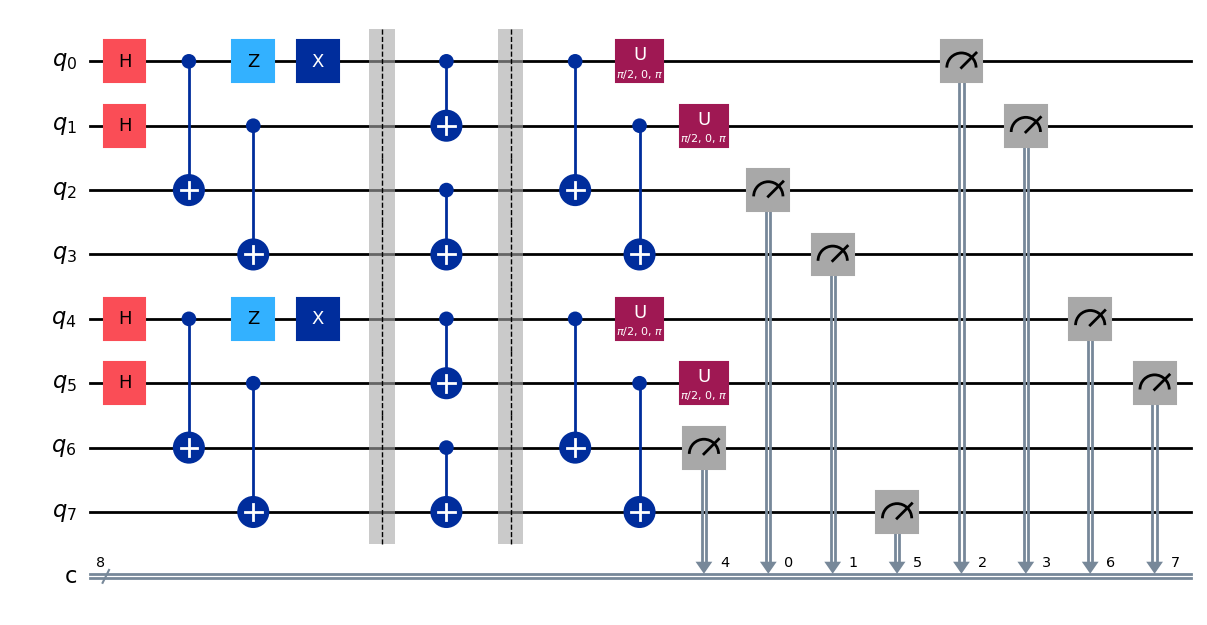

In [11]:
# == Drawing out tester circuits ==
tester_circuit_to_view = get_clifford_tester_circuit(H, 1, [1, 0])
print("Entire Weyl-Choi state")
_ = tester_circuit_to_view.draw("mpl")
print("Bell state + Weyl operator")
_ = tester_circuit_to_view.decompose(reps=1).draw("mpl")
print("Base gates")
_ = tester_circuit_to_view.decompose(reps=2).draw("mpl")